The source code is in the public domain and not licensed or under
copyright. The information and software may be used freely by the public.
As required by 17 U.S.C. 403, third parties producing copyrighted works
consisting predominantly of the material produced by U.S. government
agencies must provide notice with such work(s) identifying the U.S.
Government material incorporated and stating that such material is not
subject to copyright protection.

Derived works shall not identify themselves in a manner that implies an
endorsement by or an affiliation with the Naval Research Laboratory.

RECIPIENT BEARS ALL RISK RELATING TO QUALITY AND PERFORMANCE OF THE
SOFTWARE AND ANY RELATED MATERIALS, AND AGREES TO INDEMNIFY THE NAVAL
RESEARCH LABORATORY FOR ALL THIRD-PARTY CLAIMS RESULTING FROM THE ACTIONS
OF RECIPIENT IN THE USE OF THE SOFTWARE.

The discrete Hankel transform is written in matrix form as

$\hat{A} = HA$

Here, $A$ is a column vector representing a discretized function of radius, whose values are a vector potential frequency component.  The continuous analog would be $A(r;z=z_0,\omega=\omega_0)$.  Searay calculates $H$ numerically by diagonalizing the discretized Laplacian operator on the specific radial grid. In order to make the eigensytem tractable $H$ is symmetrized.  The symmetrized problem is

$(\Lambda \hat{A}) = S(\Lambda A$)

where $S = \Lambda H \Lambda^{-1}$, and $\Lambda$ is a diagonal matrix whose entries are, to within a constant factor, the square root of the volume of the radial cell corresponding to the row.  For the power spectrum it is convenient to normalize away the axial size and use

$\Lambda^2 = \pi r_{n+1}^2 - \pi r_n^2 \approx 2\pi r \Delta r$

Then the power at a given frequency is

$P = C\omega^2 A^\dag \Lambda^2 A$

where $C$ is a calibration factor.  The same formula holds in the Hankel-transformed space

$P = C\omega^2 \hat{A}^\dag \Lambda^2 \hat{A}$

In particular, $C$ and $\Lambda$ are the same in either representation.  The calibration factor can be worked out by computing the energy in the time domain first.  Call this $U_0$.  Then

$C = U_0 / \Delta\omega \sum_\omega \omega^2 A^\dag \Lambda^2 A$

The units of $P$ are then determined entirely by $U_0/\Delta\omega$.  The other quantities can be in any units, so long as they are everywhere consistent.  N.b. $\Delta\omega$ in rad/s is schematic, you can replace it with Hz, wavenumbers, etc.

One can work out the calibration factor using any data, just make sure the time domain and frequency domain data are the same data.  A typical pattern is to use the data on the input plane for calibration.

In [323]:
import sys
sys.path.append('../../modules')
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy import constants as C
import grid_tools as grid
import init
# The following line provides interactive plots, and requires the ipympl package.
#%matplotlib widget

In [324]:
def get_Lambda2(rn):
    dr = rn[1] - rn[0]
    return np.pi*(rn+0.5*dr)**2 - np.pi*(rn-0.5*dr)**2

def get_cal_factor(A,wn,rn,U0,dw):
    '''Get calibration factor scaled to produce units of U0/dw.  The units of A,wn,rn can be anything,
    so long as they stay the same wherever the calibration is used.  Cal is same in r or kr space.
    
    :param np.ndarray A: vector potential in frequency domain
    :param np.ndarray wn: frequency nodes
    :param np.ndarray rn: radial nodes
    :param np.ndarray U0: total energy for calibration (see above)
    :param np.ndarray dw: frequency interval for calibration (see above)'''
    Iw = get_spectral_intensity(A,wn,0,1)
    Pw = get_spectral_power(Iw,rn)
    return U0/dw/np.sum(Pw)

def get_radial_mode(tool,n,Nr):
    '''Remember modes come out in order of *decreasing* wiggles,
    i.e. the first one has the most oscillations, the last one is most like J0.'''
    Ak = np.zeros((1,Nr,1)).astype(np.complex128)
    Ak[0,n,0] = 1
    Ar = tool.rspace(Ak)
    return Ar[0,:,0]

def get_time_domain_amplitude(A,z):
    '''Get normalized vector potential in time domain
    
    :param np.ndarray A: vector potential in frequency domain with shape (w,r,phi,z)
    :param int z: index into z slice of A'''
    return np.fft.irfft(A[...,z],axis=0)

def get_time_domain_intensity(A,wn,z,mks_length):
    '''Get mks intensity assuming args are in simulation units, except for mks_length (meters)
    
    :param np.ndarray A: vector potential in frequency domain with shape (w,r,phi,z)
    :param np.ndarray wn: frequency nodes
    :param int z: index into z slice of A
    :param float mks_length: normalizing length involved in other args'''
    E2 = np.fft.irfft(1j*wn[...,np.newaxis,np.newaxis]*A[...,z],axis=0)**2
    E2 *= (C.m_e*C.c**2/mks_length/C.e)**2
    return E2/377

def get_time_domain_power(intensity_mks,rn_mks):
    '''Get mks power assuming args are in simulation units, except for mks_length (meters)
    
    :param np.ndarray intensity: mks intensity with shape (t,r,phi)
    :param np.ndarray rn: radial nodes'''
    L2_mks = get_Lambda2(rn_mks)
    return np.sum(intensity_mks[:,:,0]*L2_mks[np.newaxis,:],axis=1)

def get_spectral_intensity(A,wn,z,C):
    '''Get I(w,r) or I(w,kr) in units determined by calibration factor `C`
    
    :param np.ndarray A: vector potential in w-r or w-kr space, with shape (w,r,phi,z)
    :param np.ndarray wn: frequency nodes
    :param int z: index into z slice of A
    :param np.ndarray C: calibration from `get_cal_factor`'''
    return C * np.abs(A[...,z]*wn[...,np.newaxis,np.newaxis])**2

def get_spectral_power(spectral_intensity,rn):
    '''Get P(w) in units determined by calibration factor `C` used to get `spectral_intensity`
    
    :param np.ndarray spectral_intensity: spectral intensity with shape (w,r,phi)
    :param np.ndarray rn: radial nodes'''
    L2 = get_Lambda2(rn)
    return np.sum(spectral_intensity[:,:,0]*L2[np.newaxis,:],axis=1)


(cl_refs,args) = init.setup_opencl(['rays.py','run','file=none','platform=cuda'])
cl_refs.add_program('../../kernels','fft')

Device =  NVIDIA TITAN V
Device Memory =  12.884443136  GB


Text(0, 0.5, 'radius ($r\\omega_0/c$)')

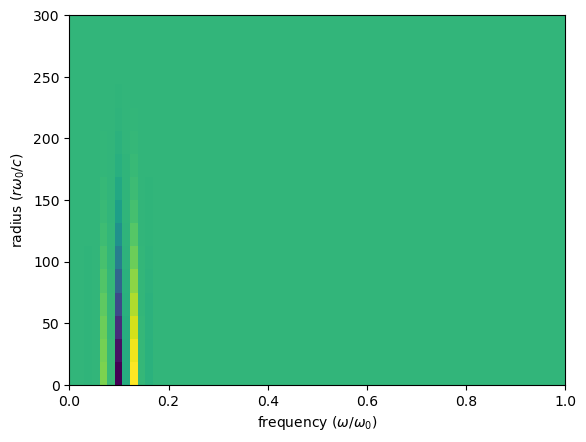

In [325]:
# init tool and test data
w00 = 0.1
dw00 = .03
r00 = 100
rmax = 300
Nw = 65
Nr = 16
Nz = 3
dr = rmax/Nr
tool = grid.HankelTransformTool(Nr,dr,0,cl_refs,Nr)
tool.AllocateDeviceMemory((Nw,Nr,1))
wn = np.linspace(0,1,Nw)
rn = np.linspace(0.5*dr,rmax-0.5*dr,Nr)
A = np.zeros((Nw,Nr,1,Nz)).astype(np.complex128)
A[:,:,0,0] = np.outer(np.exp(-1j*wn*100)*np.exp(-(wn-w00)**2/dw00**2),np.exp(-rn**2/r00**2))
A[:,:,0,1] = A[:,:,0,0] * 0.8
A[:,:,0,2] = A[:,:,0,1] * 0.8
plt.imshow(np.real(A[:,:,0,0]).swapaxes(0,1),origin='lower',aspect='auto',extent=[0,1,0,rmax])
plt.xlabel("frequency ($\omega/\omega_0$)")
plt.ylabel("radius ($r\omega_0/c$)")


Text(0, 0.5, 'amplitude')

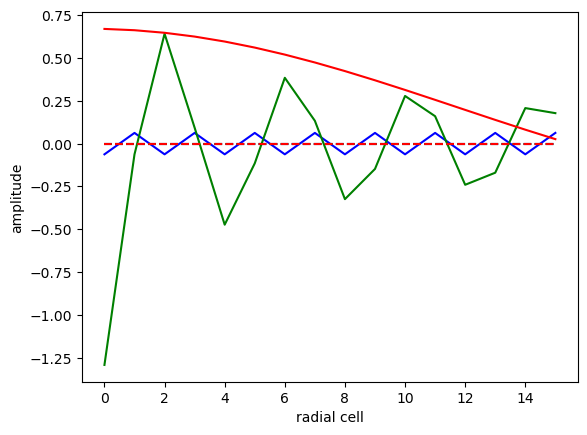

In [326]:
# Look at a few modes
tool.AllocateDeviceMemory((1,Nr,1))
plt.plot(np.real(get_radial_mode(tool,0,Nr)),color='blue')
plt.plot(np.imag(get_radial_mode(tool,0,Nr)),color='blue',linestyle='--')
plt.plot(np.real(get_radial_mode(tool,int(Nr/2),Nr)),color='green')
plt.plot(np.imag(get_radial_mode(tool,int(Nr/2),Nr)),color='green',linestyle='--')
plt.plot(np.real(get_radial_mode(tool,Nr-1,Nr)),color='red')
plt.plot(np.imag(get_radial_mode(tool,Nr-1,Nr)),color='red',linestyle='--')
plt.xlabel("radial cell")
plt.ylabel("amplitude")

Text(0, 0.5, 'amplitude')

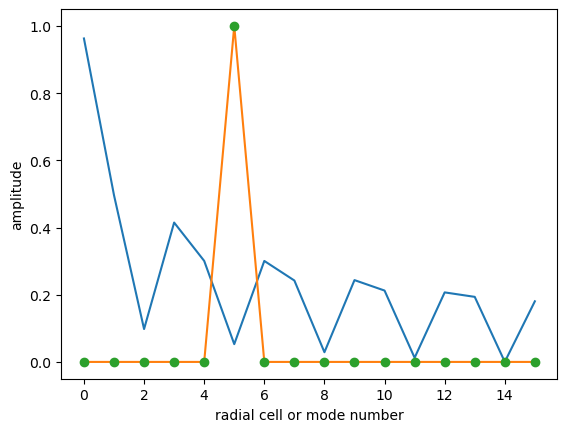

In [327]:
# Check invertibility
check_mode = 5
Ak = np.zeros((1,Nr,1)).astype(np.complex128)
Ak[0,check_mode,0] = 1
Ar = tool.rspace(Ak)
Ak2 = tool.kspace(Ar)
plt.plot(np.abs(Ar[0,:,0]))
plt.plot(np.abs(Ak[0,:,0]))
plt.plot(np.abs(Ak2[0,:,0]),'o')
plt.xlabel("radial cell or mode number")
plt.ylabel("amplitude")

period = 33.356409519815195 fs
7.017482258163533e-06 joules


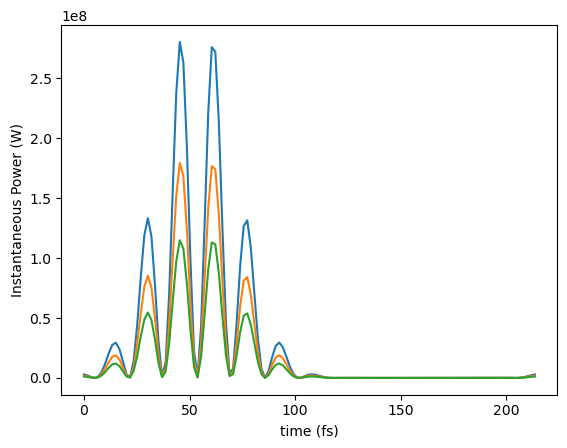

In [328]:
# Get pulse energy by integrating in space and time domains.
mks_length = 1e-6/2/np.pi
mks_time = mks_length/C.c
w_mks = wn*C.c/mks_length
dt = np.pi/w_mks[-1]
t = np.linspace(0,dt*(2*Nw-2),2*Nw-2)
Pt = []
for zn in range(3):
    I_mks = get_time_domain_intensity(A,wn,zn,mks_length)
    Pt += [get_time_domain_power(I_mks,rn*mks_length)]
plt.figure(1)
plt.plot(t*1e15,Pt[0])
plt.plot(t*1e15,Pt[1])
plt.plot(t*1e15,Pt[2])
plt.xlabel("time (fs)")
plt.ylabel("Instantaneous Power (W)")

U0 = np.sum(Pt[0])*dt
print('period =',1e15*mks_time*2*np.pi/w00,'fs')
print(U0,'joules')

7.0174822581635315e-06 joules


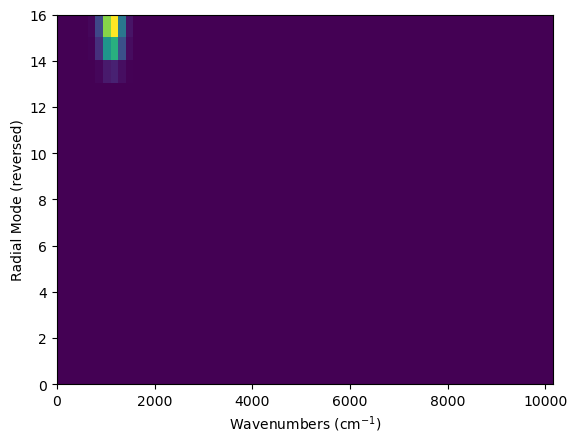

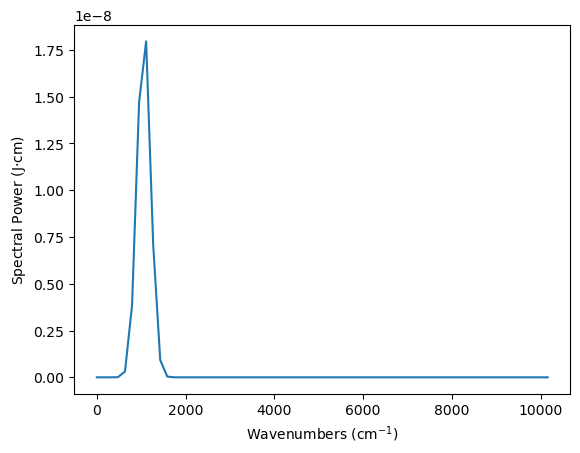

In [329]:
# Get pulse energy by integrating in modal and frequency domains.
dw_icm = (wn[1]-wn[0])/mks_time/2/np.pi/C.c/100
icm_nodes = np.linspace(0,dw_icm*Nw,Nw)
cal = get_cal_factor(A,wn,rn,U0,dw_icm)
tool = grid.HankelTransformTool(Nr,dr,0,cl_refs,Nr)
tool.AllocateDeviceMemory((Nw,Nr,1))
Awk = A.copy()
tool.kspace(Awk) # in 4D the argument is changed in place
Iwk = get_spectral_intensity(Awk,wn,0,cal)
plt.figure(1)
plt.imshow(Iwk[:,:,0].swapaxes(0,1),origin='lower',aspect='auto',extent=[0,dw_icm*Nw,0,Nr])
plt.xlabel("Wavenumbers (cm$^{-1}$)")
plt.ylabel("Radial Mode (reversed)")

Pw = get_spectral_power(Iwk,rn)
plt.figure(2)
plt.plot(icm_nodes,Pw)
plt.xlabel('Wavenumbers (cm$^{-1}$)')
plt.ylabel('Spectral Power (J$\cdot$cm)')
print(np.sum(Pw)*dw_icm,'joules')